<a href="https://colab.research.google.com/github/BriouaNorElHouda/py/blob/main/landv3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import requests
import os
import io
import cv2
import shutil
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D ,GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD

import time

In [3]:
labels = {
    'AnnualCrop': 0,
    'Forest': 1,
    'HerbaceousVegetation': 2,
    'Highway': 3,
    'Industrial': 4,
    'Pasture': 5,
    'PermanentCrop': 6,
    'Residential': 7,
    'River': 8,
    'SeaLake': 9,
}

In [4]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/EuroSatDS.zip'

extracted_path = "/content/EuroSatDS"
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extracted_path)

data = []

src_path = os.path.join(extracted_path, "EuroSatDS")
subclass = sorted(os.listdir(src_path))

def create_data():
    for sclass in subclass:
        path = os.path.join(src_path, sclass)
        class_num = subclass.index(sclass)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (64, 64))
            data.append([new_array, class_num])

create_data()

print("Total samples in the dataset:", len(data))

100%|██████████| 2500/2500 [00:00<00:00, 8789.32it/s]

Total samples in the dataset: 22000


In [5]:

X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class MyDataGenerator(keras.utils.Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.num_samples = len(X)

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, self.num_samples)

        batch_X = self.X[start:end]
        batch_y = self.y[start:end]

        batch_X = np.array(batch_X).reshape(-1,64, 64, 3) / 255.0
        batch_y = np.array(batch_y)

        return batch_X, batch_y

batch_size = 32
train_generator = MyDataGenerator(X_train, y_train, batch_size)
test_generator = MyDataGenerator(X_test, y_test, batch_size)


In [ ]:
NAME="M3043"

model=Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),  activation='relu',  input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

tensorboard= TensorBoard(log_dir="logs\{}".format(NAME))

model.compile(loss='sparse_categorical_crossentropy',
              sgd_optimizer = SGD(
               learning_rate=0.0001,
               momentum=0.9,
               nesterov=True
)
             # optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])


history = model.fit(train_generator, epochs=50,batch_size=32, validation_data=test_generator,callbacks=[tensorboard])

Epoch 1/50
1100/1100 [==============================] - 12s 7ms/step - loss: 1.5425 - accuracy: 0.3818 - val_loss: 1.1950 - val_accuracy: 0.5757
Epoch 2/50
1100/1100 [==============================] - 7s 7ms/step - loss: 1.0892 - accuracy: 0.5897 - val_loss: 0.9712 - val_accuracy: 0.6382
Epoch 3/50
1100/1100 [==============================] - 8s 7ms/step - loss: 0.9426 - accuracy: 0.6479 - val_loss: 0.8813 - val_accuracy: 0.6864
Epoch 4/50
1100/1100 [==============================] - 7s 6ms/step - loss: 0.8317 - accuracy: 0.6968 - val_loss: 0.7377 - val_accuracy: 0.7295
Epoch 5/50
1100/1100 [==============================] - 8s 7ms/step - loss: 0.7762 - accuracy: 0.7117 - val_loss: 0.7120 - val_accuracy: 0.7389
Epoch 6/50
1100/1100 [==============================] - 8s 7ms/step - loss: 0.7327 - accuracy: 0.7278 - val_loss: 0.7311 - val_accuracy: 0.7375
Epoch 7/50
1100/1100 [==============================] - 8s 7ms/step - loss: 0.7008 - accuracy: 0.7392 - val_loss: 0.6428 - val_accuracy

In [ ]:

# Define your data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=180,
    shear_range=0.1,
    zoom_range=0.1,  # Zoom in/out by 10% or less
    horizontal_flip=True,  # Horizontal flip
)

# Custom data generator with data augmentation
class MyAugmentedDataGenerator(keras.utils.Sequence):
    def __init__(self, X, y, batch_size, datagen):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.num_samples = len(X)
        self.datagen = datagen

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, self.num_samples)

        # Get batch data
        batch_X = np.array(self.X[start:end]).reshape(-1, 64, 64, 3)
        batch_y = np.array(self.y[start:end])

        # Apply data augmentation
        augmented_X = self.datagen.flow(batch_X, shuffle=False, batch_size=self.batch_size).next()

        return augmented_X, batch_y


# Create the data generator with augmentation
batch_size = 32
train_generator_augmented = MyAugmentedDataGenerator(X_train, y_train, batch_size, datagen)


In [ ]:
from keras.applications import vgg16
convgg = vgg16.VGG16(include_top=False,
           input_shape=(64, 64, 3))

In [6]:
base_model = keras.applications.ResNet50(include_top=False,
    input_shape=(64, 64, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [7]:
NAME="M35"

model=Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

tensorboard= TensorBoard(log_dir="logs\{}".format(NAME))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Now fit your model with the augmented data generator
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[tensorboard]
)

Epoch 1/50
550/550 [==============================] - 83s 68ms/step - loss: 0.5319 - accuracy: 0.8381 - val_loss: 7.4000 - val_accuracy: 0.0632
Epoch 2/50
550/550 [==============================] - 36s 65ms/step - loss: 0.1459 - accuracy: 0.9543 - val_loss: 0.7413 - val_accuracy: 0.8143
Epoch 3/50
550/550 [==============================] - 36s 65ms/step - loss: 0.0748 - accuracy: 0.9772 - val_loss: 0.1506 - val_accuracy: 0.9620
Epoch 4/50
550/550 [==============================] - 36s 66ms/step - loss: 0.0536 - accuracy: 0.9819 - val_loss: 0.2422 - val_accuracy: 0.9384
Epoch 5/50
550/550 [==============================] - 36s 66ms/step - loss: 0.0682 - accuracy: 0.9799 - val_loss: 0.2145 - val_accuracy: 0.9480
Epoch 6/50
550/550 [==============================] - 50s 91ms/step - loss: 0.0443 - accuracy: 0.9856 - val_loss: 0.2450 - val_accuracy: 0.9436
Epoch 7/50
550/550 [==============================] - 39s 71ms/step - loss: 0.0532 - accuracy: 0.9841 - val_loss: 0.3101 - val_accuracy:

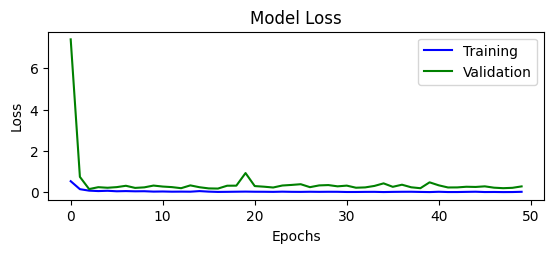

In [8]:
#Plot Model Loss
plt.subplot(211)
plt.title('Model Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='green', label='test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'],loc='upper right')

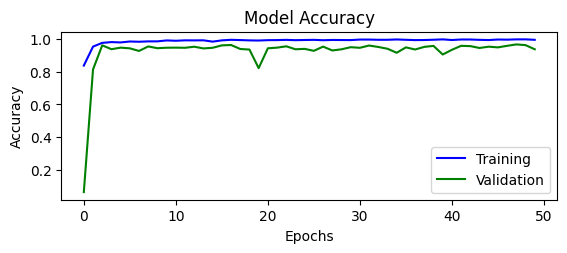

In [9]:
# Plot Accuracy
plt.subplot(211)
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='green', label='test')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'],loc='lower right')

In [10]:
save_path = '/content/drive/MyDrive/Colab Notebooks/MyModels/landRN.h5'
model.save(save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


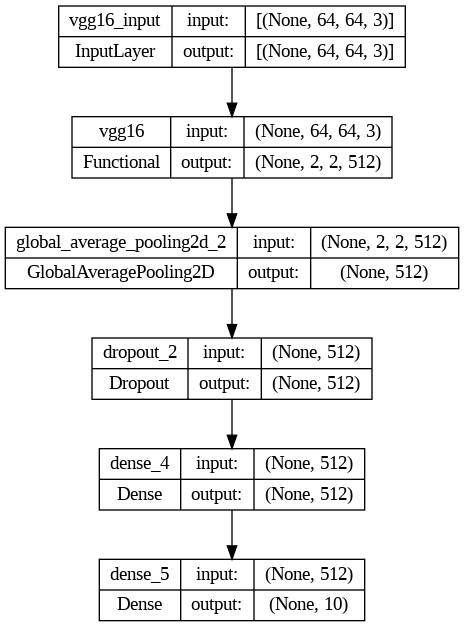

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 14982474 (57.15 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [12]:
#Testing predictions on model
from tensorflow.keras.preprocessing import image

labels = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"]


def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(64,64,3))
    img_array = image.img_to_array(img)
    img_array = img_array/ 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

path = "/content/EuroSatDS/EuroSatDS/Forest/Forest_2060.jpg"
img = preprocess_image(path)


predictions = model.predict(img)
predicted_class_index = np.argmax(predictions)

print(predictions)
predicted_class = labels[predicted_class_index]

print("Predicted class:", predicted_class)


1/1 [==============================] - 0s 24ms/step
[[7.9054230e-01 1.5546256e-01 3.9908256e-02 1.3614243e-03 1.5749842e-04
  3.3980731e-03 6.3162548e-03 1.8039811e-04 1.6026200e-03 1.0705955e-03]]
Predicted class: AnnualCrop


138/138 [==============================] - 4s 16ms/step


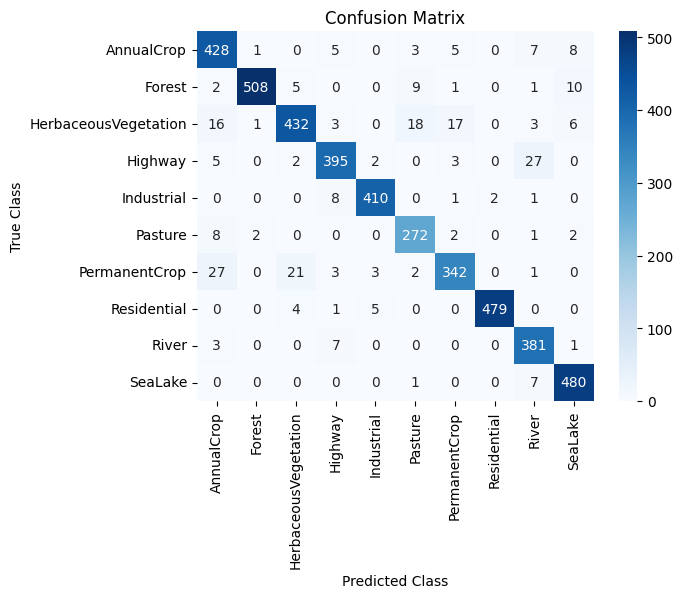

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

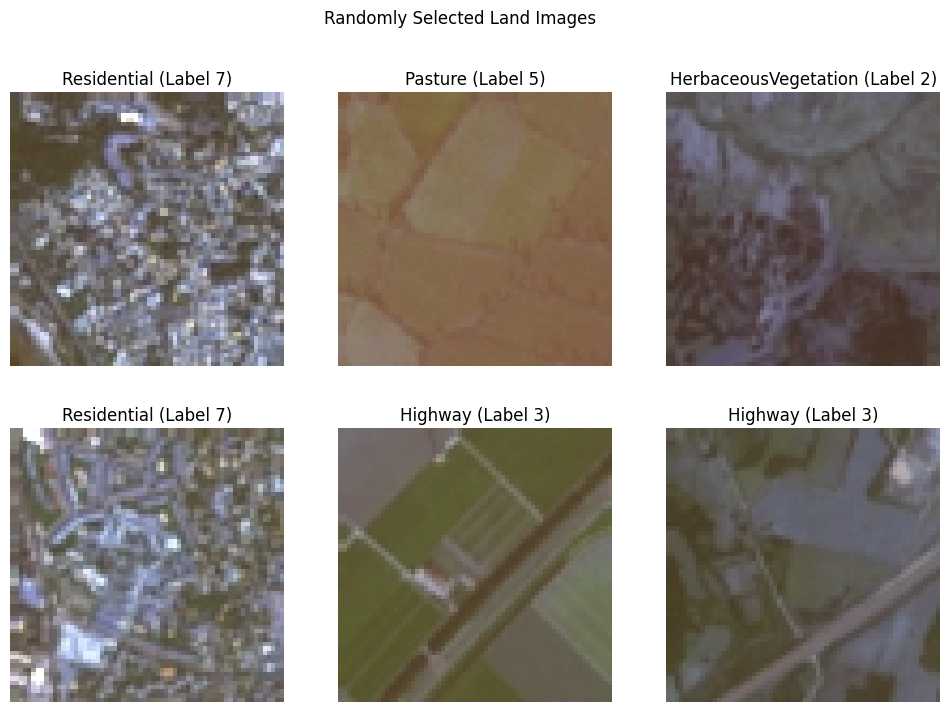

In [ ]:
import random
types = {'AnnualCrop': 0,
         'Forest': 1,
          'HerbaceousVegetation': 2,
          'Highway': 3,
          'Industrial': 4,
          'Pasture': 5,
          'PermanentCrop': 6,
          'Residential': 7,
          'River': 8,
          'SeaLake': 9,
          }

image_files = []
for root, dirs, files in os.walk(src_path):
    for file in files:
        if file.endswith(".jpg"):
            image_files.append((os.path.join(root, file), os.path.basename(root)))

random_images = random.sample(image_files, 6)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Randomly Selected Land Images')

for i, (image_file, land_name) in enumerate(random_images):
    img_array = cv2.imread(image_file, cv2.IMREAD_COLOR)
    new_array = cv2.resize(img_array, (64, 64))

    row_index = i // 3
    col_index = i % 3

    label_number = types[land_name]
    axes[row_index, col_index].imshow(new_array,  cmap=None)
    axes[row_index, col_index].set_title(f'{land_name} (Label {label_number})')
    axes[row_index, col_index].axis('off')

plt.show()